In [1]:
!pip install tensorflow

In [2]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence                     # conversion to numerical form of data
import gensim                                                # word2vec for embedding matrix
import string
from gensim.models import Word2Vec
import logging
from nltk.corpus import stopwords
from textblob import Word
import pandas as pd
from gensim.models.phrases import Phrases, Phraser

C:\Users\jaysriva\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
df=pd.read_csv('./labeledTrainData.tsv', delimiter = '\t')
df.shape

(25000, 3)

In [5]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


<AxesSubplot:>

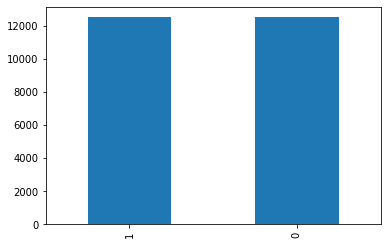

In [7]:
df.sentiment.value_counts().plot(kind='bar')

In [8]:
df.sentiment.value_counts()*100/len(df)

1    50.0
0    50.0
Name: sentiment, dtype: float64

# Preprocessing

In [9]:
import re
def clean_string(string):
    try:
        string=re.sub(r'^https?:\/\/<>.*[\r\n]*', '', string, flags=re.MULTILINE)
        string=re.sub(r"[^A-Za-z]", " ", string)  
        word=string.strip().lower().split()
        word=[w for w in word if len(w)>=1]
        return ' '.join(word)
    except:
        return ''
df['clean_review']=df['review'].apply(clean_string)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...
3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious s...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            25000 non-null  object
 1   sentiment     25000 non-null  int64 
 2   review        25000 non-null  object
 3   clean_review  25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


In [11]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(df['review'],df['sentiment'],test_size=0.2,random_state=1234)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape,ytrain.sum(),ytest.sum())

(20000,) (5000,) (20000,) (5000,) 10049 2451


In [12]:
from keras.preprocessing.text import Tokenizer
top_words=10000
tokenizer=Tokenizer(top_words)
tokenizer.fit_on_texts(xtrain)

In [13]:
tokenizer.word_index.items()

dict_items([('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('be', 26), ('he', 27), ('one', 28), ('all', 29), ('at', 30), ('by', 31), ('an', 32), ('they', 33), ('so', 34), ('who', 35), ('from', 36), ('like', 37), ('her', 38), ('or', 39), ('just', 40), ('about', 41), ('out', 42), ("it's", 43), ('has', 44), ('if', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('when', 50), ('more', 51), ('very', 52), ('up', 53), ('she', 54), ('time', 55), ('even', 56), ('my', 57), ('no', 58), ('would', 59), ('which', 60), ('only', 61), ('story', 62), ('really', 63), ('their', 64), ('see', 65), ('had', 66), ('can', 67), ('me', 68), ('were', 69), ('well', 70), ('than', 71), ('we', 72), ('much', 73), ('been', 74), ('will', 75), ('get

In [14]:
xtrain.head()

6617     When Gundam0079 became the movie trilogy most ...
16547    Antonioni was aiming for another hip masterpie...
16196    Tourists head to Ireland for a school trip to ...
11646    \Freddy's Dead\" did the smartest thing it cou...
3203     Sistas in da hood. Looking for revenge and bli...
Name: review, dtype: object

In [15]:
# Conversion  to list of ints
xtrain=tokenizer.texts_to_sequences(xtrain)
xtest=tokenizer.texts_to_sequences(xtest)
xtrain[:5]
# Now that we have a numerical representation of the words in the initial data set.
# This is required becuase we are going to use the word embeding in Keras(i.e. the Word2Vec implementation) 
# to convert the review words to an vector in n-dimensional space(n is a tuning parameter here) 
# and embeding layer requries the input to be in the numerical form

[[50,
  859,
  1,
  17,
  2294,
  87,
  4,
  175,
  23,
  1086,
  16,
  3,
  173,
  4,
  9,
  13,
  2055,
  202,
  2,
  325,
  4,
  231,
  333,
  11,
  6,
  1849,
  1,
  1937,
  148,
  61,
  316,
  3,
  2603,
  674,
  9,
  216,
  1072,
  16,
  202,
  18,
  893,
  180,
  1,
  104,
  286,
  202,
  848,
  8,
  11,
  10,
  261,
  23,
  194,
  5,
  4712,
  68,
  99,
  322,
  34,
  109,
  4431,
  191,
  100,
  2,
  10,
  13,
  346,
  1568,
  15,
  3,
  6807,
  17,
  11,
  17,
  117,
  3,
  767,
  282,
  4,
  12,
  48,
  163,
  11,
  17,
  751,
  42,
  6,
  12,
  284,
  192,
  3134,
  4,
  1,
  314,
  25,
  49,
  2,
  79,
  83,
  9,
  90,
  1,
  305,
  51,
  387,
  241,
  71,
  1,
  200,
  100,
  119,
  519,
  2383,
  14,
  1,
  327,
  2134,
  4,
  433,
  3946,
  87,
  83,
  12,
  89,
  37,
  2115,
  12,
  206,
  910,
  5,
  103,
  11,
  17,
  4180,
  409,
  9,
  34,
  458,
  389,
  9,
  5,
  3,
  173,
  4,
  83,
  40,
  15,
  1,
  1166,
  314,
  62,
  45,
  332,
  3,
  4431,
  337,
  2,
  75

In [16]:
# Pad Sequences in the review.Max sequence of 300 words , we will fix since each sequence is of different length
from keras.preprocessing import sequence
max_review_length=300
xtrain=sequence.pad_sequences(xtrain,maxlen=max_review_length,padding='post')
xtest=sequence.pad_sequences(xtest,maxlen=max_review_length,padding='post')
len(xtrain[0])

300

In [17]:
xtrain.shape,xtest.shape

((20000, 300), (5000, 300))

In [18]:
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hines...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...
3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious s...


In [19]:
!pip install textblob

In [20]:
# embedding matrix using word2vec
import string
from gensim.models import Word2Vec
import logging
from nltk.corpus import stopwords
from textblob import Word
import pandas as pd

#displaying the list of stopwords
stop = stopwords.words('english')
#dataframe
df_w2v = pd.read_csv('./labeledTrainData.tsv', delimiter = '\t')

# df_w2v['clean_review_w2v'] = df_w2v['review'].apply(', '.join)
# cleaning the data using the NLP approach
# print(df_w2v)
df_w2v['clean_review_w2v'] = df_w2v['review'].apply(lambda x:' '.join(x.lower() for x in x.split()))
df_w2v['clean_review_w2v']= df_w2v['clean_review_w2v'].apply(lambda x: ' '.join(x for x in x.split() if x not in string.punctuation))
df_w2v['clean_review_w2v']= df_w2v['clean_review_w2v'].str.replace('[^\w\s]','')
df_w2v['clean_review_w2v']= df_w2v['clean_review_w2v'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
df_w2v['clean_review_w2v'] = df_w2v['clean_review_w2v'].apply(lambda x:' '.join(x for x in x.split() if not x in stop))
df_w2v['clean_review_w2v'] = df_w2v['clean_review_w2v'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# #taking the outer list
# print(df_w2v)
# bigger_list=[]
# for i in df['clean_review_w2v']:
#     li = list(i.split(" "))
#     bigger_list.append(li)
# #structure of data to be taken by the model.word2vec
# print("Data format for the overall list:",bigger_list)
# #custom data is fed to machine for further processing
# model = Word2Vec(bigger_list, min_count=1,size=50,workers=4)
# # model = Word2Vec(bigger_list, min_count=1,size=300,workers=4)
# #print(model)

In [21]:
df_clean=pd.DataFrame({'clean':df_w2v['clean_review_w2v']})
df_clean.shape

(25000, 1)

In [22]:
from gensim.models.phrases import Phrases, Phraser
sent=[row.split() for row in df_clean['clean']]
print(sent)
# # word_freq = defaultdict(int)
# for i in sent:
#     word_freq[i] += 1
# len(word_freq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
from collections import defaultdict  # For word frequency
word_freq = defaultdict(int)
for i in sent:
    for ind in i:
        word_freq[ind] += 1
len(word_freq)

111093

In [24]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['br',
 'movie',
 'film',
 'one',
 'like',
 'time',
 'good',
 'character',
 'story',
 'even']

In [25]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=0, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=0,
                     workers=4)


In [26]:
w2v_model.build_vocab(sent, progress_per=10000)
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(84164430, 92346930)

In [27]:
w2v_model.wv.most_similar(positive=["br"])

[('outdoor', 0.2292928546667099),
 ('delon', 0.21884390711784363),
 ('cat', 0.21598900854587555),
 ('first', 0.19780313968658447),
 ('galore', 0.1957741230726242),
 ('recently', 0.19374994933605194),
 ('ought', 0.18435834348201752),
 ('concentrated', 0.18269392848014832),
 ('give', 0.18215590715408325),
 ('watchable', 0.18199633061885834)]

In [28]:
w2v_model.wv.similarity("br", "film")

0.033168413

In [29]:
w2v_model.wv.doesnt_match(['br', 'film', 'like'])

'like'

In [30]:
# Analogy difference:Which word is to woman as homer is to marge?
w2v_model.wv.most_similar(positive=["iron", "man"], negative=["black"], topn=3)

[('seriouslybr', 0.2055121809244156),
 ('transformer', 0.19625823199748993),
 ('bronte', 0.19368372857570648)]

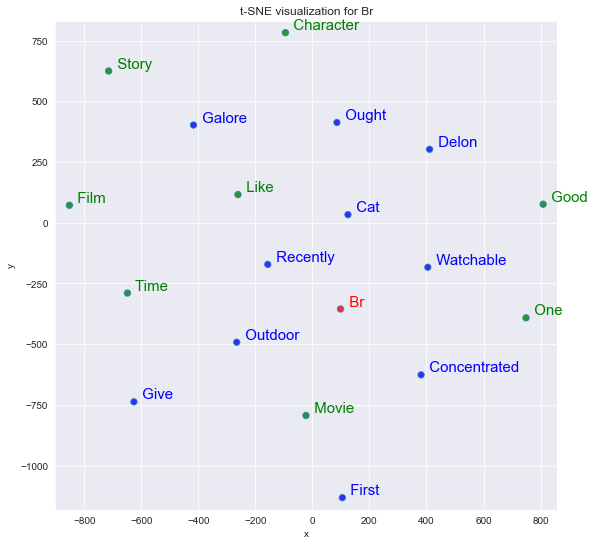

In [31]:
# compare where the vector representation of Br, its 10 most similar words from the model, as well as 8 random ones,in a 2D graph:

# t-SNE visualizations:
# t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
# Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
tsnescatterplot(w2v_model, 'br', ['film', 'movie', 'story', 'one', 'like', 'time', 'good','character'])

In [32]:
w2v_model.wv.most_similar(positive=["br"])
# Interestingly, the 10 most similar words to Br ends up around it

[('outdoor', 0.2292928546667099),
 ('delon', 0.21884390711784363),
 ('cat', 0.21598900854587555),
 ('first', 0.19780313968658447),
 ('galore', 0.1957741230726242),
 ('recently', 0.19374994933605194),
 ('ought', 0.18435834348201752),
 ('concentrated', 0.18269392848014832),
 ('give', 0.18215590715408325),
 ('watchable', 0.18199633061885834)]

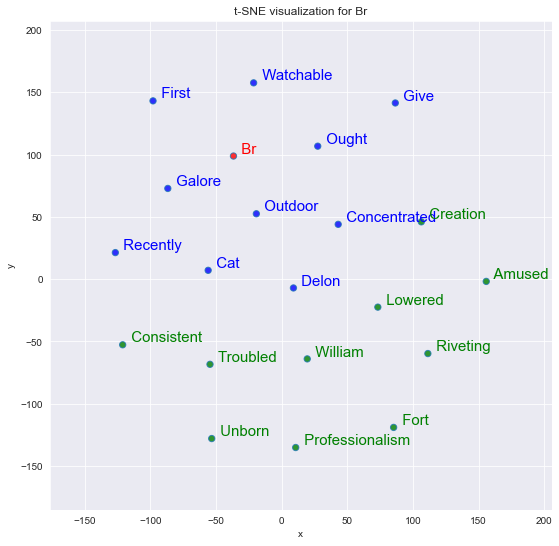

In [33]:
# compare where the vector representation of Br and its 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Br:
tsnescatterplot(w2v_model, 'br', [i[0] for i in w2v_model.wv.most_similar(negative=["br"])])

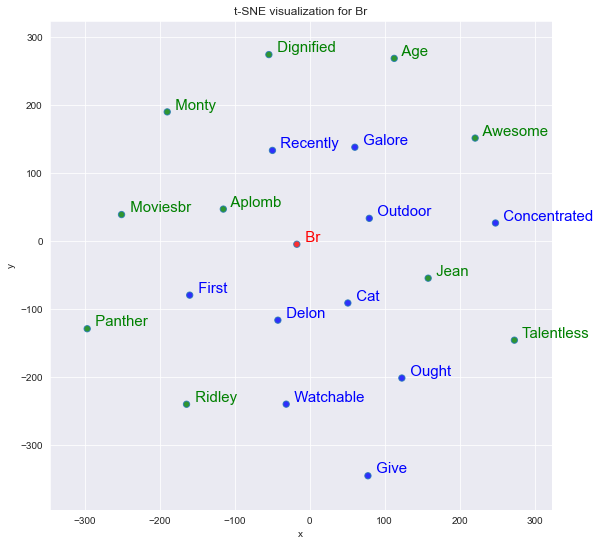

In [34]:
# 10 Most similar words vs. 11th to 20th Most similar words:¶
# Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:


tsnescatterplot(w2v_model, "br", [t[0] for t in w2v_model.wv.most_similar(positive=["br"], topn=20)][10:])

In [36]:
w2v_model.wv.vectors.shape

(12091, 300)

In [37]:
w2v_model.save("word2vec_movie_review.model")
w2v_model.save("model.bin")

In [38]:
import gensim
word2vec=gensim.models.Word2Vec.load('word2vec_movie_review.model')
word2vec.wv.vectors.shape #This means each vector is of length 300 dimension

(12091, 300)

In [39]:
# we will create an embeding Matrix for our Vocab. Above gensim model already has the vector representation of 
# all the majority of the words. We will leverage the model and try to get the vectors of our use case 
# and we will store them in a matrix
embedding_vector_length= word2vec.wv.vectors.shape[1]
embedding_matrix=np.zeros((top_words+1,embedding_vector_length))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i>top_words:
        break
    if word in word2vec.wv.index_to_key:
        embedding_vector=word2vec.wv[word]
        embedding_matrix[i]=embedding_vector

In [41]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00124814,  0.00041928,  0.00169723, ...,  0.00138664,
         0.00154314, -0.00265209],
       [ 0.00016621, -0.00009145,  0.00134314, ..., -0.00022143,
        -0.00220064, -0.00306525]])

In [42]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout,Dense,LSTM
model=Sequential()
model.add(Embedding(top_words+1,300,input_length=max_review_length,weights=[embedding_matrix],trainable=False))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


#  Embedding layer takes the input encoded seqeuence of text and convert them a vector in a 50- dimensional space note: Embedding layer takes 3 key parameters as input
# The vacab size
# max length of the document( review in our case)
# vector dimension of the each word we want the model to generate
# The input of the LSTM is always is a 3D array. (batch_size, time_steps, seq_len)
# The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument. If return_sequence is False, the output is a 2D array. (batch_size, units) If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)
# Since we have not set the flag, output is a 2D array .i.e. Batchsize By output value( using LSTM Gates)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          3000300   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,160,801
Trainable params: 160,501
Non-trainable params: 3,000,300
_________________________________________________________________


In [43]:
model.fit(xtrain,ytrain,epochs=10,batch_size=100,validation_data=(xtest,ytest))

Epoch 1/10
200/200 [==============================] - 857s 4s/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.4902
Epoch 2/10
200/200 [==============================] - 876s 4s/step - loss: 0.6931 - accuracy: 0.5062 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 3/10
200/200 [==============================] - 965s 5s/step - loss: 0.6931 - accuracy: 0.4978 - val_loss: 0.6929 - val_accuracy: 0.5126
Epoch 4/10
200/200 [==============================] - 1027s 5s/step - loss: 0.6931 - accuracy: 0.4977 - val_loss: 0.6930 - val_accuracy: 0.5198
Epoch 5/10
200/200 [==============================] - 1046s 5s/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6929 - val_accuracy: 0.5020
Epoch 6/10
200/200 [==============================] - 1024s 5s/step - loss: 0.6928 - accuracy: 0.5117 - val_loss: 0.6929 - val_accuracy: 0.5034
Epoch 7/10
200/200 [==============================] - 1021s 5s/step - loss: 0.6928 - accuracy: 0.5066 - val_loss: 0.6928 - val_accuracy: 0.